## fastjet -> coffea demo for C$^3$ meeting
June 23, 2023

In [1]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda

Import events from root file into coffea:

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

In [69]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1) # define jets with kt algorithm with R=1

In [87]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)


In [98]:
select_pfos = dak.zip(
    {
        'x': events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].x,
        'y': events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].y,
        'z': events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].z,
        't': events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].energy,
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].behavior,
)

In [92]:
# run first line to use 

# cluster = fastjet.ClusterSequence(events.PandoraPFOs[(abs(events.PandoraPFOs.pdgId) == 13) != True], jetdef).exclusive_jets(n_jets=2) # create jets

cluster = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2) # create jets

In [100]:
cluster.compute() # error occurs when plotting if that's when you compute but it's already here 

Select only the events without a muon pair with an invariant mass between 80 and 100 GeV:

In [84]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)


# bit of a sketchy way of masking but it works and is quick
truth_arr = dak.ones_like(dak.num(events.PandoraPFOs)) == dak.ones_like(dak.num(events.PandoraPFOs)) 
no_muons = muonsevent != truth_arr
select_clst = cluster[muonsevent]

Set up the jets as 4-vectors in coffea

In [95]:
jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=select_pfos.behavior,
)

In [96]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 


hist_jets = (
    hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

RuntimeError: Caught an unknown exception!

Grab the indices of the particles that went into the jets

In [8]:
pfo_index = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets_constituent_index(njets=2)

Get the PDG IDs of the linked MC particles to the PFOs that went into the jets (slice for the events we're looking at above)

In [23]:
linked_gen = events.PandoraPFOs.matched_gen # grab the generator particled linked to the PFOs

linked_pdg = linked_gen.pdgId[dak.flatten(pfo_index,axis=2)][no_muons]

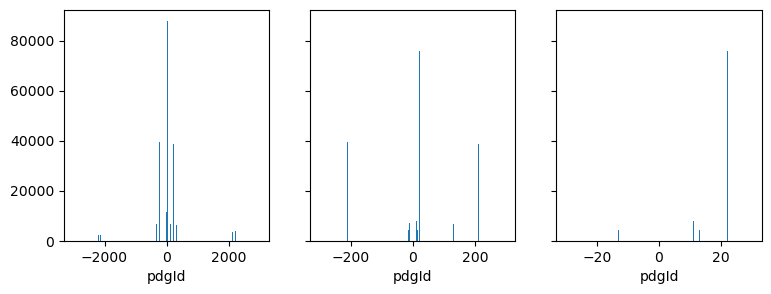

In [28]:
# having to not use dask plotting because of flattening problem
# with matched particles having different shape 
linked_pdg_a = linked_pdg.compute() 

fig,axs = plt.subplots(1,3,sharey=True, figsize=(9, 3))

axs[0].hist(ak.flatten(ak.flatten(linked_pdg_a,axis=2),axis=1),range=(-3000,3000),bins=200)
axs[1].hist(ak.flatten(ak.flatten(linked_pdg_a,axis=2),axis=1),range=(-300,300),bins=200)
axs[2].hist(ak.flatten(ak.flatten(linked_pdg_a,axis=2),axis=1),range=(-30,30),bins=200)

for n in range(len(axs)): axs[n].set_xlabel('pdgId')

### A Problem I Ran Into 
(possibly a bug in fastjet?)

Originally, I tried to select the events I wanted before running them through fastjet and it produced some errors and weird results.

In [54]:
# selecting the events I want 
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

# select_pfos = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True]
select_pfos = events.PandoraPFOs[(abs(events.PandoraPFOs.pdgId) == 13) != True]


# running this through fastjet and setting up with coffea

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
cluster = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)

jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

Different plot than above:

In [55]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


hist_clusters = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_clusters.compute().plot1d(label='Jets')
dak.necessary_columns(hist_clusters)

plt.plot([125,125],[0,15],'darkgrey')

RuntimeError: Caught an unknown exception!

Indices out of range when trying to return constituents:

In [44]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)[5].compute() # show example

<Array [[107, 163, 177, ..., 2544, 2582, 2583], ...] type='2 * var * int32'>

In [47]:
dak.num(select_pfos)[5].compute() # should be the max index 

43

(also there are two functions and `exclusive_jets_consituents_index()` does not work)

Constituents not being able to be returned either:

In [49]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituents(njets=2).compute()

IndexError: cannot slice ListArray (of length 2314) with [[20, 25, 32, 34, 40, 41, 42, 62, ..., 87, 91, 105, 113, 114, 116, 117], ...]: index out of range while attempting to get index 62 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-17/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

This error occurred while attempting to slice

    <RecoParticleArray [[[{x: 0.29, ...}, ...], ...], ...] type='1157 * var...'>

with

    <Array [[[20, 25, ..., 116, 117], ...], ...] type='1157 * var * var * int32'>